In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections.abc import Sequence
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import metrics
from sklearn.metrics import roc_curve, classification_report, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
df = pd.read_csv('./ALLFLOWMETER_HIKARI2021.CSV')

In [4]:
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

In [5]:
df.head()

,uid,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,Cg61Jch3vdz9DBptj,103.255.15.23,13316,128.199.242.104,443,2.207588,15,14,6,6,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,1
1,CdRIlqLWdj35Y9vW9,103.255.15.23,13318,128.199.242.104,443,15.624266,15,14,6,6,...,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,1
2,CLzp9Khd0Y09Qkgrg,103.255.15.23,13320,128.199.242.104,443,12.203357,14,13,6,5,...,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,1
3,Cnf1YA4iLB4CSNWB88,103.255.15.23,13322,128.199.242.104,443,9.992448,14,13,6,5,...,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,1
4,C4ZKvv3fpO72EAOsJ6,103.255.15.23,13324,128.199.242.104,443,7.780611,14,14,6,5,...,7.545305e+06,7.545305e+06,7.545305e+06,7.545305e+06,0.0,29200,65160,0,Bruteforce-XML,1


In [6]:
df['traffic_category'].value_counts(normalize=True)

Benign                 0.625688
Background             0.306425
Probing                0.042119
Bruteforce             0.010596
Bruteforce-XML         0.009266
XMRIGCC CryptoMiner    0.005905
Name: traffic_category, dtype: float64

In [7]:
# Only want to look at probing for the problem statement and there is a decent amount of data for this
df[df['traffic_category'] == 'Probing']

,uid,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
528611,CGUZ413E20vOAvNhB6,103.255.15.150,33864,128.199.242.104,443,134.545802,1308,2571,1290,1292,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200,65160,0,Probing,1
528612,CtEHvV2t8Szv3EMrH4,103.255.15.150,33866,128.199.242.104,443,133.710978,1287,2530,1264,1269,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200,65160,0,Probing,1
528613,Ck8Zli1W2a7NZ1LYf2,103.255.15.150,33868,128.199.242.104,443,133.558816,1280,2525,1263,1265,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200,65160,0,Probing,1
528614,CWTrKw3CQJJ6cxZIV1,103.255.15.150,33870,128.199.242.104,443,133.516534,17,17,7,8,...,2.756750e+07,1.051647e+08,1.327322e+08,6.636612e+07,5.486954e+07,29200,65160,0,Probing,1
528615,CDlGBc2wH71BlkMHWb,103.255.15.150,33872,128.199.242.104,443,133.430967,1287,2544,1270,1274,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200,65160,0,Probing,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551994,CWnqOE3MwhYBqWV0l5,103.255.15.150,33848,128.199.242.104,443,0.249909,10,14,3,8,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200,65160,402,Probing,1
551995,Cc9GuT23r4uUSE8Syf,103.255.15.150,33852,128.199.242.104,443,0.253536,9,12,3,7,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200,65160,402,Probing,1
551996,CEo1Cq1YIRzA5Tmzyi,103.255.15.150,33854,128.199.242.104,443,0.258555,9,12,3,7,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200,65160,402,Probing,1
551997,CwnAuE4prskuSDNTq6,103.255.15.150,33856,128.199.242.104,443,0.244943,10,13,3,8,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200,65160,402,Probing,1


In [8]:
df.dtypes

uid                     object
originh                 object
originp                  int64
responh                 object
responp                  int64
                         ...  
fwd_init_window_size     int64
bwd_init_window_size     int64
fwd_last_window_size     int64
traffic_category        object
Label                    int64
Length: 86, dtype: object

In [9]:
df.describe()

,originp,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Label
count,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,...,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,555278.000000,555278.000000,555278.000000,555278.000000
mean,38673.198034,5082.161647,9.306544,18.264091,18.892578,7.956928,15.803417,1720.704202,1674.140666,3394.844869,...,1.335883e+05,3.490637e+06,5.000630e+06,8.312942e+06,4.073219e+06,7.992576e+05,14750.725718,21005.879513,4546.872210,0.067887
std,18071.825216,12915.812900,101.802730,463.901484,469.078877,73.441224,467.349374,4994.579973,4548.503983,9316.856663,...,8.289045e+06,1.804930e+07,2.326516e+07,9.683372e+07,1.915958e+07,7.206576e+06,15003.491439,29155.406813,11069.456088,0.251552
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,28581.000000,53.000000,0.000311,1.000000,1.000000,1.000000,0.000000,4.430152,3.168143,7.624355,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,42693.500000,443.000000,0.026218,2.000000,2.000000,2.000000,2.000000,39.760205,43.938937,82.775849,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5840.000000,0.000000,0.000000,0.000000
75%,53120.000000,443.000000,0.347231,10.000000,12.000000,3.000000,5.000000,80.376058,80.237673,160.578254,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200.000000,65160.000000,402.000000,0.000000
max,65535.000000,65522.000000,17393.030600,326292.000000,326827.000000,3953.000000,326822.000000,223696.213333,110376.421053,223696.213333,...,5.438463e+09,2.998038e+08,2.998038e+08,1.738680e+10,2.998038e+08,2.029962e+08,65535.000000,65535.000000,65535.000000,1.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555278 entries, 0 to 555277
Data columns (total 86 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   uid                       555278 non-null  object 
 1   originh                   555278 non-null  object 
 2   originp                   555278 non-null  int64  
 3   responh                   555278 non-null  object 
 4   responp                   555278 non-null  int64  
 5   flow_duration             555278 non-null  float64
 6   fwd_pkts_tot              555278 non-null  int64  
 7   bwd_pkts_tot              555278 non-null  int64  
 8   fwd_data_pkts_tot         555278 non-null  int64  
 9   bwd_data_pkts_tot         555278 non-null  int64  
 10  fwd_pkts_per_sec          555278 non-null  float64
 11  bwd_pkts_per_sec          555278 non-null  float64
 12  flow_pkts_per_sec         555278 non-null  float64
 13  down_up_ratio             555278 non-null  f

In [11]:
df = df[(df['traffic_category'] == 'Benign') | (df['traffic_category'] == 'Probing')]

In [36]:
fvalue_selector = SelectKBest(f_classif, k=10)
X_best_features = fvalue_selector.fit_transform(
    df.select_dtypes(include=[np.number]).drop(columns=['Label']), df['Label'])

/Users/joshualin/Desktop/env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [23 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/joshualin/Desktop/env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [38]:
df.columns[fvalue_selector.get_support(indices=True)].tolist()

['fwd_pkts_per_sec',
 'down_up_ratio',
 'fwd_header_size_min',
 'fwd_header_size_max',
 'bwd_header_size_min',
 'flow_CWR_flag_count',
 'fwd_pkts_payload.max',
 'fwd_bulk_packets',
 'idle.tot',
 'idle.avg']

In [41]:
df.groupby('Label')['fwd_pkts_per_sec'].mean()

Label
0    1184.568194
1      34.322741
Name: fwd_pkts_per_sec, dtype: float64

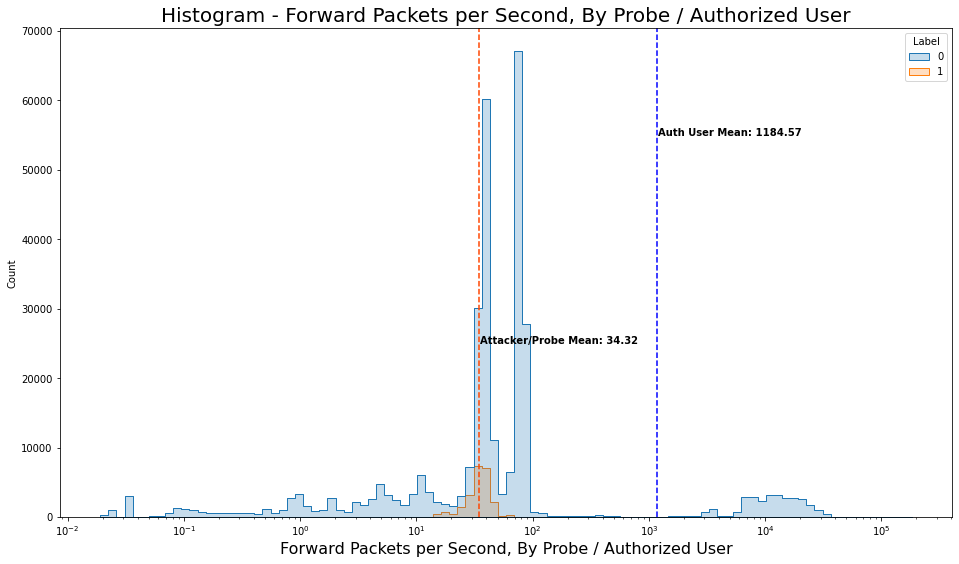

In [44]:
plt.figure(figsize=(16,9))
plt.title('Histogram - Forward Packets per Second, By Probe / Authorized User', fontsize=20)
plt.xlabel('Forward Packets per Second, By Probe / Authorized User', fontsize=16)

auth_user_fp_mean = df.groupby('Label')['fwd_pkts_per_sec'].mean()[0]
attacker_fp_mean = df.groupby('Label')['fwd_pkts_per_sec'].mean()[1]

# Auth User Mean Line
plt.axvline(
    auth_user_fp_mean, 
    c='blue', 
    ls='--')
plt.text(
    auth_user_fp_mean + 2, 
    55000,
    f'Auth User Mean: {round(auth_user_fp_mean, 2)}',
    weight='bold')

# Attacker Mean Line
plt.axvline(
    attacker_fp_mean, 
    c='orangered', 
    ls='--')
plt.text(
    attacker_fp_mean + 1, 
    25000,
    f'Attacker/Probe Mean: {round(attacker_fp_mean, 2)}',
    weight='bold')

sns.histplot(df[df['fwd_pkts_per_sec'] > 0], x='fwd_pkts_per_sec', hue='Label', element='step', log_scale=True, bins=100);

In [45]:
# Not enough observations to represent on a visualization
df.groupby('Label')['flow_CWR_flag_count'].mean()

Label
0    0.000147
1    0.000000
Name: flow_CWR_flag_count, dtype: float64

In [50]:
df.groupby('Label')['idle.tot'].mean()

Label
0    7.381650e+06
1    3.468229e+05
Name: idle.tot, dtype: float64

In [51]:
df.groupby('Label')['idle.avg'].mean()

Label
0    4.015026e+06
1    2.389896e+05
Name: idle.avg, dtype: float64

In [40]:
df.groupby('Label')['flow_duration'].mean()

Label
0    8.261962
1    2.585869
Name: flow_duration, dtype: float64

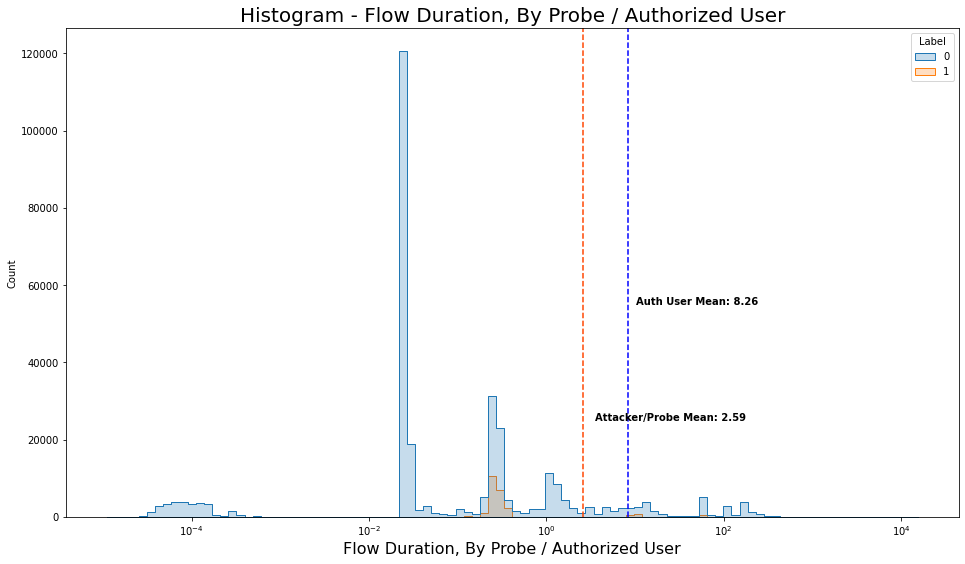

In [13]:
plt.figure(figsize=(16,9))
plt.title('Histogram - Flow Duration, By Probe / Authorized User', fontsize=20)
plt.xlabel('Flow Duration, By Probe / Authorized User', fontsize=16)

auth_user_fd_mean = df.groupby('Label')['flow_duration'].mean()[0]
attacker_fd_mean = df.groupby('Label')['flow_duration'].mean()[1]

# Auth User Mean Line
plt.axvline(
    auth_user_fd_mean, 
    c='blue', 
    ls='--')
plt.text(
    auth_user_fd_mean + 2, 
    55000,
    f'Auth User Mean: {round(auth_user_fd_mean, 2)}',
    weight='bold')

# Attacker Mean Line
plt.axvline(
    attacker_fd_mean, 
    c='orangered', 
    ls='--')
plt.text(
    attacker_fd_mean + 1, 
    25000,
    f'Attacker/Probe Mean: {round(attacker_fd_mean, 2)}',
    weight='bold')

sns.histplot(df[df['flow_duration'] > 0], x='flow_duration', hue='Label', element='step', log_scale=True, bins=100);

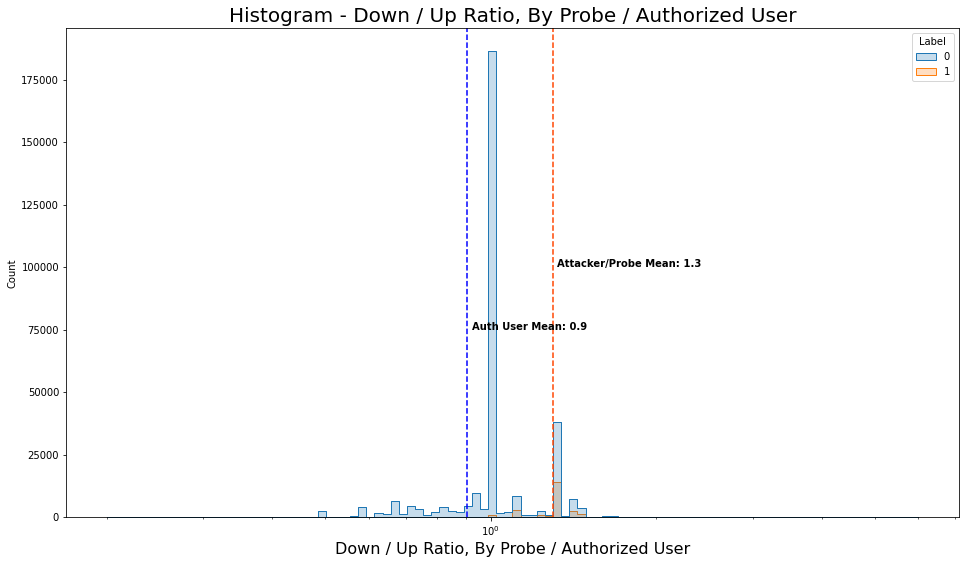

In [14]:
plt.figure(figsize=(16,9))
plt.title('Histogram - Down / Up Ratio, By Probe / Authorized User', fontsize=20)
plt.xlabel('Down / Up Ratio, By Probe / Authorized User', fontsize=16)

auth_user_dur_mean = df.groupby('Label')['down_up_ratio'].mean()[0]
attacker_dur_mean = df.groupby('Label')['down_up_ratio'].mean()[1]

# Auth User Mean Line
plt.axvline(
    auth_user_dur_mean, 
    c='blue', 
    ls='--')
plt.text(
    auth_user_dur_mean + .02, 
    75000,
    f'Auth User Mean: {round(auth_user_dur_mean, 2)}',
    weight='bold')

# Attacker Mean Line
plt.axvline(
    attacker_dur_mean, 
    c='orangered', 
    ls='--')
plt.text(
    attacker_dur_mean + .02, 
    100000,
    f'Attacker/Probe Mean: {round(attacker_dur_mean, 2)}',
    weight='bold')

sns.histplot(df[df['down_up_ratio'] > 0], x='down_up_ratio', hue='Label', element='step', log_scale=True, bins=100);

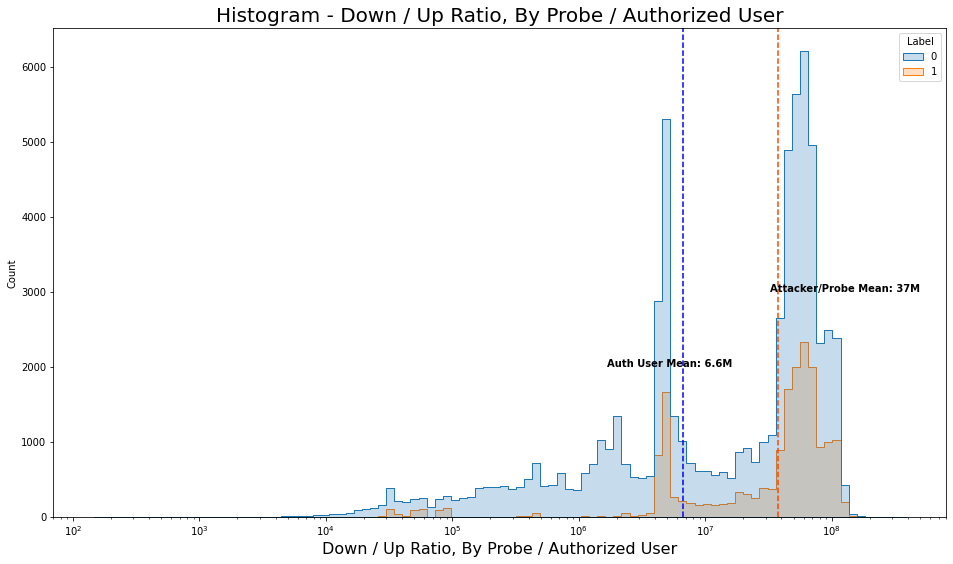

In [15]:
plt.figure(figsize=(16,9))
plt.title('Histogram - Down / Up Ratio, By Probe / Authorized User', fontsize=20)
plt.xlabel('Down / Up Ratio, By Probe / Authorized User', fontsize=16)

auth_user_bbulk_mean = df.groupby('Label')['bwd_bulk_rate'].mean()[0]
attacker_bbulk_mean = df.groupby('Label')['bwd_bulk_rate'].mean()[1]

# Auth User Mean Line
plt.axvline(
    auth_user_bbulk_mean, 
    c='blue', 
    ls='--')
plt.text(
    auth_user_bbulk_mean - 5000000, 
    2000,
    f'Auth User Mean: 6.6M',
    weight='bold')

# Attacker Mean Line
plt.axvline(
    attacker_bbulk_mean, 
    c='orangered', 
    ls='--')
plt.text(
    attacker_bbulk_mean - 5000000, 
    3000,
    f'Attacker/Probe Mean: 37M',
    weight='bold')

sns.histplot(df[df['bwd_bulk_rate'] > 0], x='bwd_bulk_rate', hue='Label', element='step', log_scale=True, bins=100);

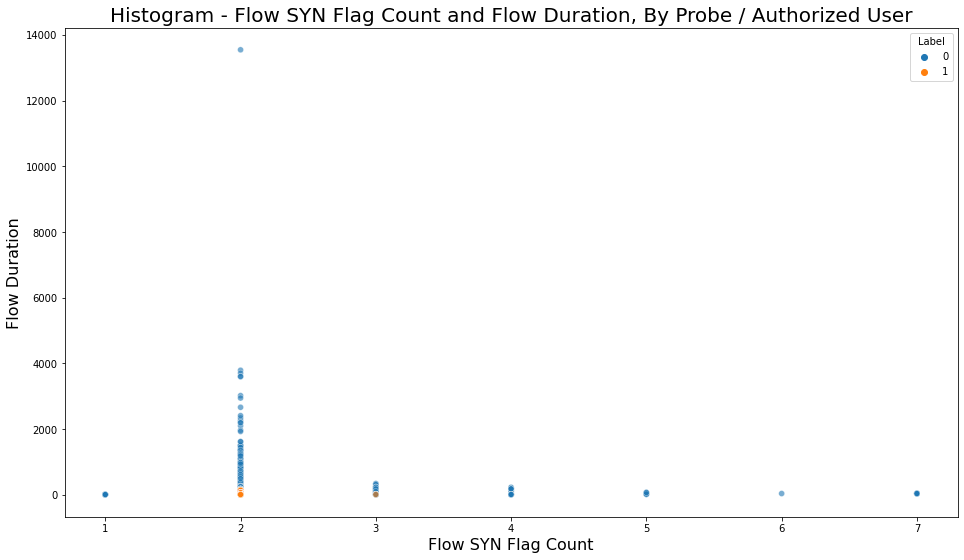

In [16]:
plt.figure(figsize=(16,9))
plt.title('Histogram - Flow SYN Flag Count and Flow Duration, By Probe / Authorized User', fontsize=20)
plt.xlabel('Flow SYN Flag Count', fontsize=16)
plt.ylabel('Flow Duration', fontsize=16)

sns.scatterplot(data=df[df['flow_SYN_flag_count'] > 0], x='flow_SYN_flag_count', y='flow_duration', hue='Label', alpha=0.6);

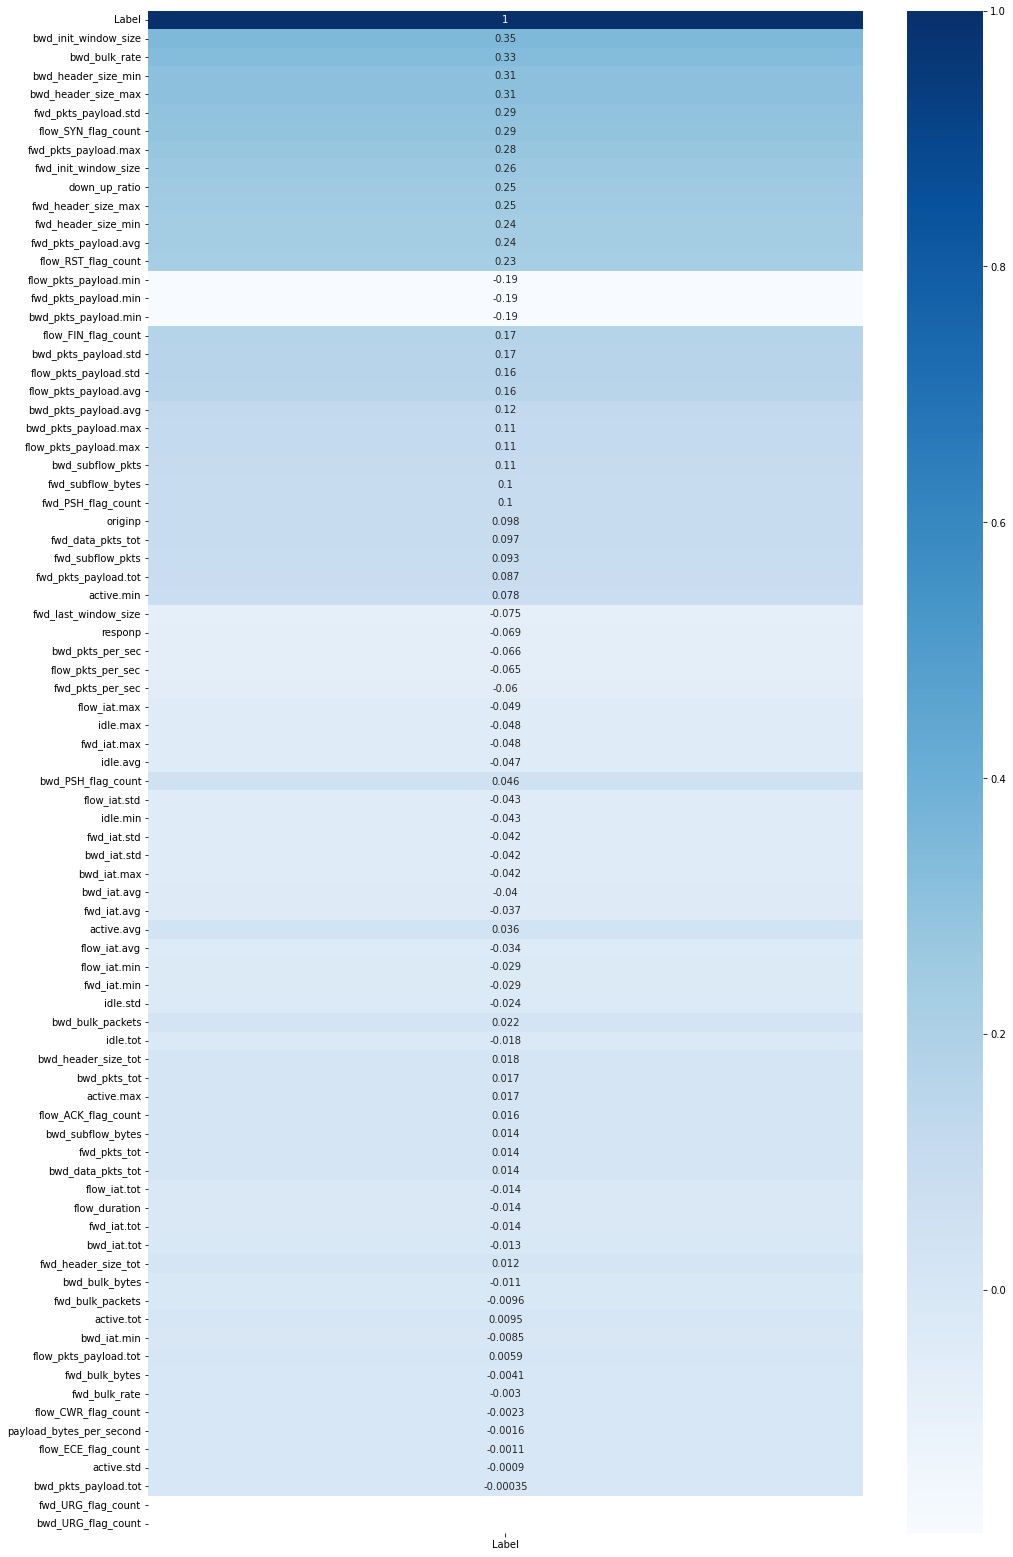

In [17]:
plt.figure(figsize=(16,28))
sns.heatmap(df.corr()[['Label']].sort_values(by='Label', ascending=False, key=abs), annot=True, cmap='Blues');

In [18]:
df_numeric = df.select_dtypes(include=[np.number])

In [19]:
df_numeric

,originp,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Label
181180,63061,1947,5359.472365,127,0,127,0,0.023696,0.000000,0.023696,...,0.0,4.206444e+07,4.307476e+07,5.359472e+09,4.253549e+07,291118.988688,0,0,0,0
181181,63061,1947,6811.639999,161,0,161,0,0.023636,0.000000,0.023636,...,0.0,4.207135e+07,4.306212e+07,6.811640e+09,4.257275e+07,285948.485423,0,0,0,0
181182,63061,1947,3277.740273,78,0,78,0,0.023797,0.000000,0.023797,...,0.0,4.206999e+07,4.306987e+07,3.277740e+09,4.256806e+07,297213.340679,0,0,0,0
181183,41956,42000,0.000182,1,1,0,0,5489.926702,5489.926702,10979.853403,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,0,29200,0
181184,37708,42001,0.000089,1,1,0,0,11214.716578,11214.716578,22429.433155,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,0,29200,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551994,33848,443,0.249909,10,14,3,8,40.014577,56.020408,96.034986,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,65160,402,1
551995,33852,443,0.253536,9,12,3,7,35.497919,47.330559,82.828479,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,65160,402,1
551996,33854,443,0.258555,9,12,3,7,34.808850,46.411800,81.220650,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,65160,402,1
551997,33856,443,0.244943,10,13,3,8,40.825841,53.073593,93.899434,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,65160,402,1


In [20]:
df['Label'].value_counts(normalize=True)

0    0.936929
1    0.063071
Name: Label, dtype: float64

In [54]:
X = df_numeric.drop(columns=['Label'])
y = df['Label']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [56]:
sm = SMOTE()
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

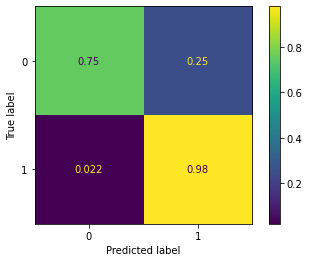

In [66]:
pipe = Pipeline([
    ('pca', PCA(
        n_components=35, 
        random_state=42
    )),
    ('mms', MinMaxScaler()),
    ('lr', LogisticRegression(
        max_iter=10000,
        random_state=42
    ))
])

pipe.fit(X_train_sm, y_train_sm)

ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, normalize='true');

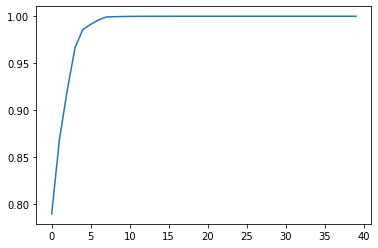

In [63]:
explained_variance = pipe[0].explained_variance_ratio_
explained_variance_cumulative = np.cumsum(explained_variance)
plt.plot(explained_variance_cumulative);